# Requirements

In [ ]:
! git clone https://github.com/mohsenfayyaz/DecompX.git
! pip install datasets
! pip install plotly
! pip install -U kaleido
! pip install openpyxl

In [1]:
# MOHSEN
import os
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv()
login(os.environ["HF_TOKEN"])
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 0 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [ ]:
# ALI
import os
os.chdir('/mounts/Users/cisintern/amodaresi/Projects/Retriever-Contextualization/')
# from dotenv import load_dotenv
from huggingface_hub import login

# load_dotenv()
login(os.environ["HF_TOKEN"])
# print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Load Dataset

In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
import transformers
from transformers import AutoTokenizer, AutoConfig

from DecompX.src.decompx_utils import DecompXConfig
from DecompX.src.modeling_bert import BertForSequenceClassification, BertModel
from DecompX.src.modeling_roberta import RobertaForSequenceClassification, RobertaModel

pd.set_option('display.max_columns', None)

### NQ
# df_raw = pd.read_pickle("hf://datasets/Retriever-Contextualization/datasets/nq/facebook--contriever-msmarco_corpus2681468.pkl")
### RE_DOCRED
df_raw = pd.read_pickle("hf://datasets/Retriever-Contextualization/datasets/re-docred/facebook--contriever-msmarco_corpus105925.pkl")
attrs = df_raw.attrs.copy()
df_raw = df_raw.merge(pd.read_pickle("hf://datasets/Retriever-Contextualization/datasets/Re-DocRED/queries_test_validation.pkl"), left_on="query_id", right_on="id")
df_raw.attrs = attrs

# df_raw.style.set_properties(**{'background-color': 'black', 'color': 'lawngreen'})
attrs

{'model': 'facebook/contriever-msmarco',
 'query_model': 'facebook/contriever-msmarco',
 'context_model': 'facebook/contriever-msmarco',
 'pooling': 'avg',
 'dataset': 're-docred',
 'corpus_size': 105925,
 'eval': {'ndcg': {'NDCG@1': 0.46109,
   'NDCG@3': 0.49878,
   'NDCG@5': 0.50989,
   'NDCG@10': 0.5215,
   'NDCG@100': 0.54809,
   'NDCG@1000': 0.56627},
  'map': {'MAP@1': 0.46109,
   'MAP@3': 0.48954,
   'MAP@5': 0.49568,
   'MAP@10': 0.50046,
   'MAP@100': 0.50531,
   'MAP@1000': 0.50593},
  'recall': {'Recall@1': 0.46109,
   'Recall@3': 0.52552,
   'Recall@5': 0.55258,
   'Recall@10': 0.58856,
   'Recall@100': 0.72008,
   'Recall@1000': 0.86709},
  'precision': {'P@1': 0.46109,
   'P@3': 0.17517,
   'P@5': 0.11052,
   'P@10': 0.05886,
   'P@100': 0.0072,
   'P@1000': 0.00087}}}

Total: 7170
Total: 7170


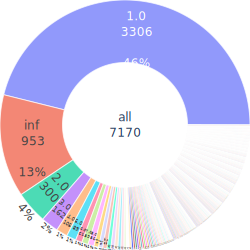

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_score,pred_doc,pred_doc_score,gold_doc_len,pred_doc_len
7150,validation16256,Where was Will Weng born?,[Will Weng],{'Will Weng': {'text': 'Will Weng ( February 2...,"{'len': 1000, 'max': 1.6899311542510986, 'min'...",{'Will Weng': 1.6899311542510986},"{'Will Weng': 1.6899311542510986, 'Weng Shilie...",{'Will Weng': {'text': 'Will Weng ( February 2...,validation16256,Will Weng,"[[{'name': 'Will Weng', 'pos': [0, 2], 'sent_i...","[{'r': 'P19', 'h': 0, 't': 7, 'evidence': [0, ...","[[Will, Weng, (, February, 25, ,, 1907, –, May...",validation,"{'r': 'P19', 'h': 0, 't': 7, 'evidence': [0, 1]}",0,"[{'name': 'Will Weng', 'pos': [0, 2], 'sent_id...","[{'name': 'Terre Haute', 'pos': [2, 4], 'sent_...","{Will Weng, Weng}",{Terre Haute},Will Weng,Terre Haute,{PER},{LOC},"[0, 1]","[[Will, Weng, (, February, 25, ,, 1907, –, May...","[{'name': 'Will Weng', 'pos': [0, 2], 'sent_id...","[{'name': 'Terre Haute', 'pos': [2, 4], 'sent_...",P19,place of birth,Where was Will Weng born?,0,{},1.0,"Will Weng ( February 25 , 1907 – May 2 , 1993 ...",1.689931,"Will Weng ( February 25 , 1907 – May 2 , 1993 ...",1.689931,161,161
7151,validation16257,Where was Will Weng educated?,[Will Weng],{'Will Weng': {'text': 'Will Weng ( February 2...,"{'len': 1000, 'max': 1.5464872121810913, 'min'...",{'Will Weng': 1.5464872121810913},"{'Will Weng': 1.5464872121810913, 'Weng Shilie...",{'Will Weng': {'text': 'Will Weng ( February 2...,validation16257,Will Weng,"[[{'name': 'Will Weng', 'pos': [0, 2], 'sent_i...","[{'r': 'P19', 'h': 0, 't': 7, 'evidence': [0, ...","[[Will, Weng, (, February, 25, ,, 1907, –, May...",validation,"{'r': 'P69', 'h': 0, 't': 9, 'evidence': [0, 1]}",1,"[{'name': 'Will Weng', 'pos': [0, 2], 'sent_id...","[{'name': 'Indiana State Teachers College', 'p...","{Will Weng, Weng}",{Indiana State Teachers College},Will Weng,Indiana State Teachers College,{PER},{ORG},"[0, 1]","[[Will, Weng, (, February, 25, ,, 1907, –, May...","[{'name': 'Will Weng', 'pos': [0, 2], 'sent_id...","[{'name': 'Indiana State Teachers College', 'p...",P69,educated at,Where was Will Weng educated?,0,{},1.0,"Will Weng ( February 25 , 1907 – May 2 , 1993 ...",1.546487,"Will Weng ( February 25 , 1907 – May 2 , 1993 ...",1.546487,161,161
7152,validation16258,Where was Will Weng educated?,[Will Weng],{'Will Weng': {'text': 'Will Weng ( February 2...,"{'len': 1000, 'max': 1.5464872121810913, 'min'...",{'Will Weng': 1.5464872121810913},"{'Will Weng': 1.5464872121810913, 'Weng Shilie...",{'Will Weng': {'text': 'Will Weng ( February 2...,validation16258,Will Weng,"[[{'name': 'Will Weng', 'pos': [0, 2], 'sent_i...","[{'r': 'P19', 'h': 0, 't': 7, 'evidence': [0, ...","[[Will, Weng, (, February, 25, ,, 1907, –, May...",validation,"{'r': 'P69', 'h': 0, 't': 12, 'evidence': [0, 3]}",2,"[{'name': 'Will Weng', 'pos': [0, 2], 'sent_id...",[{'name': 'Columbia University School of Journ...,"{Will Weng, Weng}",{Columbia University School of Journalism},Will Weng,Columbia University School of Journalism,{PER},{ORG},"[0, 3]","[[Will, Weng, (, February, 25, ,, 1907, –, May...","[{'name': 'Will Weng', 'pos': [0, 2], 'sent_id...",[{'name': 'Columbia University School of Journ...,P69,educated at,Where was Will Weng educated?,0,{},1.0,"Will Weng ( February 25 , 1907 – May 2 , 1993 ...",1.546487,"Will Weng ( February 25 , 1907 – May 2 , 1993 ...",1.546487,161,161
7153,validation16259,What conflict was Will Weng part of?,[Will Weng],{'Will Weng': {'text': 'Will Weng ( February 2...,"{'len': 1000, 'max': 1.414757251739502, 'mi

In [10]:
### df filtering
import plotly.express as px

def find_index(l, idx, not_found_value=np.inf):
    try:
        return l.index(idx)
    except:
        return not_found_value

### FILTER MULTI GOLD DOCS
print("Total:", len(df_raw))
df = df_raw.loc[df_raw["gold_docs"].str.len() == 1, :].copy()
print("Total:", len(df))
# df.drop_duplicates(subset=["query"], keep="first", inplace=True)
# print("Total:", len(df))

### COMPUTE HIT RANK
df["hit_rank"] = df.apply(lambda row: min([find_index(list(row["scores_1000"].keys()), doc_id) + 1 for doc_id in row["gold_docs"]]), axis=1)
# df["hit_rank"].hist(figsize=(8, 4), bins=50)

dfc = df.copy(); dfc["hit_rank"] = dfc["hit_rank"].astype(str);
fig = px.sunburst(dfc, path=[px.Constant("all"), 'hit_rank'], width=250, height=250)
fig.update_traces(textinfo='label+percent entry+value')
fig.update_layout(margin={'t':0,'l':0,'b':0,'r':0})
fig.show("svg")

### Prepare Docs (title+text)
df["gold_doc"] = df["gold_docs_text"].apply(lambda x: list(x.items())[0][1])
# df["gold_doc"] = df["gold_doc"].apply(lambda x: x["title"] + " " + x["text"])
df["gold_doc"] = df["gold_doc"].apply(lambda x: x["text"])
df["gold_doc_score"] = df["scores_gold"].apply(lambda x: list(x.items())[0][1])
df["pred_doc"] = df["predicted_docs_text_10"].apply(lambda x: list(x.items())[0][1])
# df["pred_doc"] = df["pred_doc"].apply(lambda x: x["title"] + " " + x["text"])
df["pred_doc"] = df["pred_doc"].apply(lambda x: x["text"])
df["pred_doc_score"] = df["scores_1000"].apply(lambda x: list(x.items())[0][1])

df["gold_doc_len"] = df["gold_doc"].str.split().apply(len)
df["pred_doc_len"] = df["pred_doc"].str.split().apply(len)


df.sort_values("hit_rank")

In [11]:
df

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_score,pred_doc,pred_doc_score,gold_doc_len,pred_doc_len
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 1.4679288864135742, 'min'...",{'Loud Tour': 1.4679288864135742},"{'Loud Tour': 1.4679288864135742, 'Poetry Bus ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,The Loud Tour was the fourth overall and third...,1.467929,The Loud Tour was the fourth overall and third...,1.467929,140,140
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 1.610438585281372, 'min':...",{'Loud Tour': 1.610438585281372},"{'Loud Tour': 1.610438585281372, 'For Unlawful...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud Tour, Loud}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [18, 19], 'sent_id...",P175,performer,Who performed Loud Tour?,0,{},1.0,The Loud Tour was the fourth overall and third...,1.610439,The Loud Tour was the fourth overall and third...,1.610439,140,140
2,test2,Which administrative territorial entity is The...,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 1.2572499513626099, 'min'...",{'Loud Tour': None},{'Palasport Olimpico and Stadio Comunale area ...,{'Palasport Olimpico and Stadio Comunale area ...,test2,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}",2,"[{'sent_id': 4, 'type': 'LOC', 'pos': [11, 14]...","[{'name': 'London', 'pos': [1, 2], 'sent_id': ...",{The O2 Arena},{London},The O2 Arena,London,{LOC},{LOC},[4],"[[In, London, ,, Rihanna, played, a, record, b...","[{'sent_id': 4, 'type': 'LOC', 'pos': [11, 14]...","[{'name': 'London', 'pos': [1, 2], 'sent_id': ...",P131,located in the administrative territorial entity,Which administrative territorial entity is The...,0,{},inf,The Loud Tour was the fourth overall and third...,NaN,The facilities that were used for the 2006 Win...,1.257250,140,201
3,test4,Which country is The O2 Arena associated with?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 1.3489434719085693, 'min'...",{'Loud Tour': 0.9447600245475769},{'Qizhong Forest Sports City Arena': 1.3489434...,{'Qizhong Forest Sports City Arena': {'text': ...,test4,Loud Tour,"[[{'name': 'Loud', 'pos

# DecompX

In [12]:
DATASET = df.attrs["dataset"]
MODEL = df.attrs["model"]  # 'facebook/contriever-msmarco'  # Only BERT or RoBERTa
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIGS = {
    "DecompX":
        DecompXConfig(
            include_biases=True,
            bias_decomp_type="absdot",
            include_LN1=True,
            include_FFN=True,
            FFN_approx_type="GeLU_ZO",
            include_LN2=True,
            aggregation="vector",
            include_classifier_w_pooler=True,
            tanh_approx_type="ZO",
            output_all_layers=True,
            output_attention=None,
            output_res1=None,
            output_LN1=None,
            output_FFN=None,
            output_res2=None,
            output_encoder=None,
            output_aggregated="vector",  # Changed
            output_pooler="norm",
            output_classifier=True,
        ),
}

def load_model_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_config = AutoConfig.from_pretrained(model_name)
    if type(model_config) is transformers.models.roberta.configuration_roberta.RobertaConfig:
        model = RobertaModel.from_pretrained(model_name)
    elif type(model_config) is transformers.models.bert.configuration_bert.BertConfig:
        model = BertModel.from_pretrained(model_name)
    else:
        raise Exception(f"Not implemented model: {model_name}")
    model.to(DEVICE)
    return model, tokenizer

model, tokenizer = load_model_tokenizer(MODEL)

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [13]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib

def print_importance(importance, tokenized_text, discrete=False, prefix=""):
    """
    importance: (sent_len)
    """
    assert len(importance) == len(tokenized_text)
    importance = importance / np.abs(importance).max() / 1.0  # Normalize
    if discrete:
        importance = np.argsort(np.argsort(importance)) / len(importance) / 1.6

    html = "<pre style='line-height: 28px; display: flex; flex-flow: row wrap;'>"+prefix
    for i in range(len(tokenized_text)):
        # if importance[i] > 0:
        #     rgba = plt.get_cmap('Reds')(importance[i] * .7)   # Wistia
        # else:
        #     rgba = plt.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
        rgba = plt.get_cmap('coolwarm')((importance[i] + 1) / 2)
        text_color = "color: rgba(255, 255, 255, 1.0); " if np.abs(importance[i]) > 1 else "color: rgba(10, 10, 10, 1.0); "
        color = f"background-color: rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]}); " + text_color
        html += (f"<div style='"
                 f"{color}"
                 f"border-radius: 5px; padding: 2px; margin: 1px;"
                 f"font-weight: {int(800)};"
                 "width: fit-content; display: flex;"
                 "'>")
        html += tokenized_text[i].replace('<', "[").replace(">", "]")
        html += "</div> "
        if tokenized_text[i] in ["hypothesis,", "hold.", '"contradiction"']:
            html += '<br>'
    return html

def html_wrapper(htmls, desc="text", legend="?"):
    html = ""
    head = """
    <head>
    <style>
        @media print {
            -webkit-print-color-adjust: exact;
        }
        fieldset {
            max-width: 1000px; padding: 8px; border-radius: 20px; border: 3px solid rgb(15, 200, 200); background: white; color: black;
        }
        legend {
            margin-left: 10px; padding: 7px; padding-left: 20px; padding-right: 20px; border: 2px solid rgb(15, 200, 200);
            border-radius: 20px; background: white;
            /*font-family: Arial !important;*/
            font-weight: 600;
        }
        table tr td {
            white-space: nowrap; padding: 5px;
        }
    </style>
    </head>
    """
    html += head
    html += f"""
        <fieldset>
            <legend>{legend}</legend>
            <table style='width: 1000px; font-weight: 600; color: black;'>
            """
    for i in range(len(htmls)):
        html += """
        <tr>
        """
        html += f"<td style='text-align: center; width: 100px;'>{desc}:</td><td>"
        html += htmls[i]
        html += "</td></tr>"
    html += "</table></fieldset>"
    return html

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/modeling_utils.py:1141: FutureWarning:

The `device` argument is deprecated and will be removed in v5 of Transformers.



torch.Size([1, 12, 768])
torch.Size([1, 147, 768])
torch.Size([1, 150, 768])


/tmp/ipykernel_1712927/2245885384.py:10: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipykernel_1712927/2245885384.py:21: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



Query:,[CLS] which country is este ##ban gomez a citizen of ? [SEP]


Gold Doc:


Pred Doc:


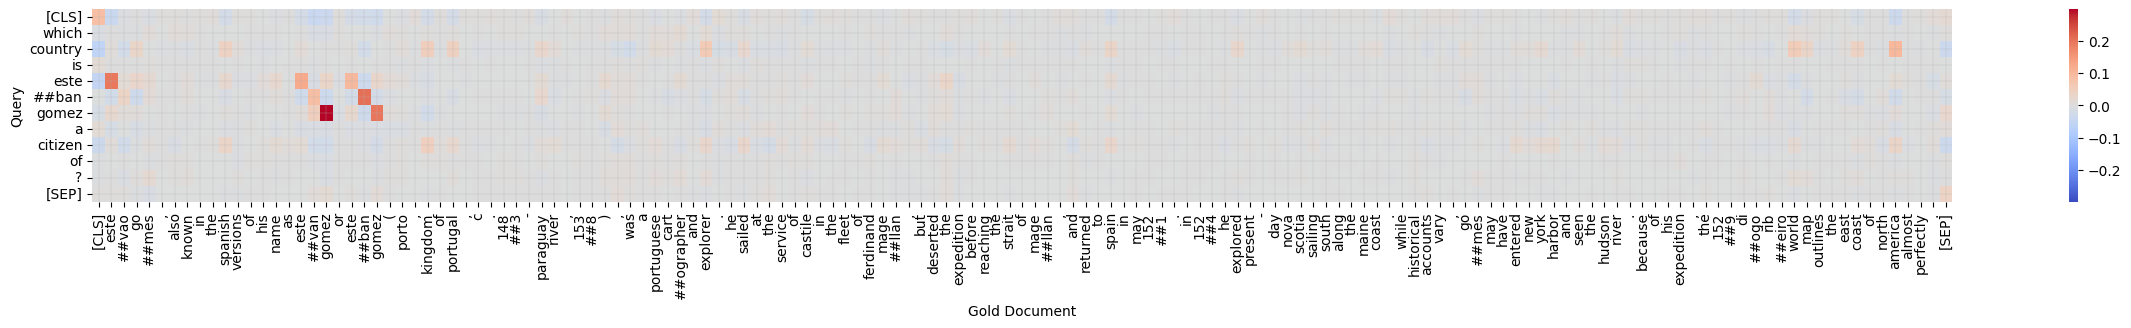

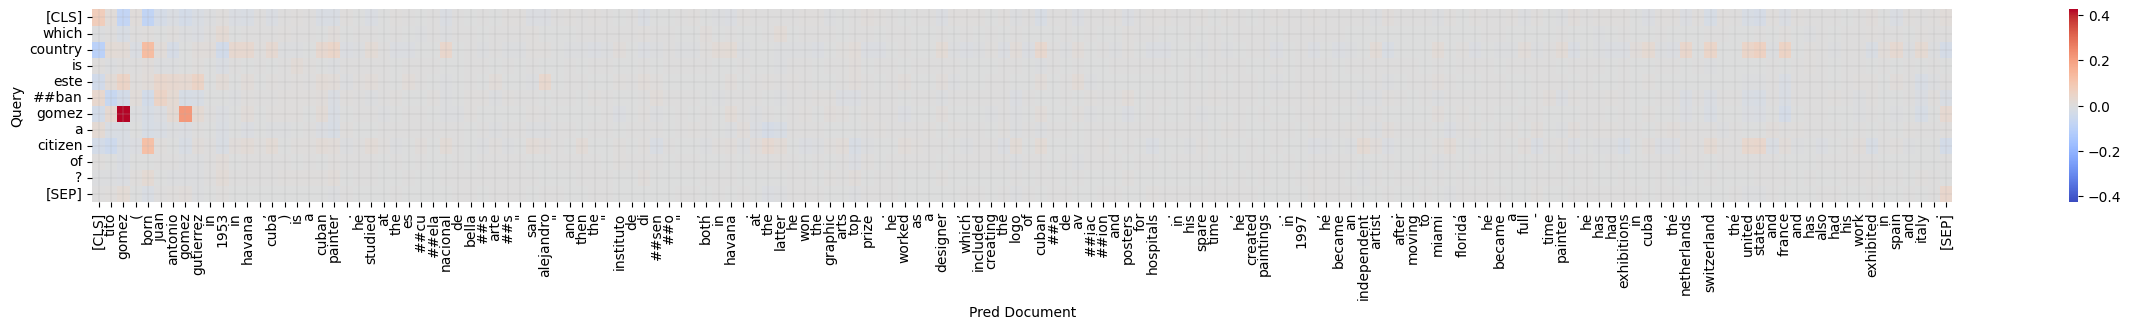

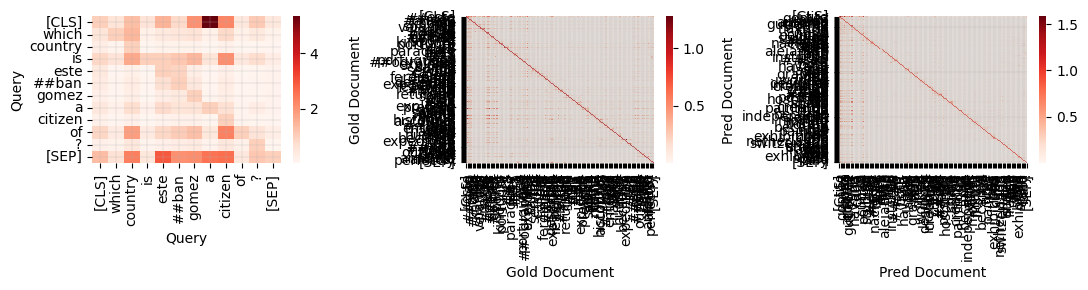

In [27]:
def run_decompx(text):
    inputs = tokenizer([text], padding=True, truncation=True, return_tensors='pt')
    input_ids = inputs["input_ids"]
    inputs.to(model.device)
    with torch.no_grad():
        last_hidden_states, pooler_output, hidden_states, decompx_last_layer_outputs, decompx_all_layers_outputs = model(
            **inputs,
            output_attentions=False,
            return_dict=False,
            output_hidden_states=True,
            decompx_config=CONFIGS["DecompX"]
        )
        ### decompx_last_layer_outputs.aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim] ###
        ### last_hidden_states ~ [1, 70, 768] ~ [batch, seq_len, emb_dim]
        print(last_hidden_states.shape)  # 
        mean_pooled = last_hidden_states[0].mean(dim=0)
        decompx_last_layer_mean = decompx_last_layer_outputs.aggregated[0][0].mean(dim=(0))  # Mean over DecompX similar to the retriever [seq_len, emb_dim]
        tokens_dot_scores = torch.einsum("ij,j->i", decompx_last_layer_mean, mean_pooled)  # [seq_len]
        ranking = torch.argsort(tokens_dot_scores, descending=True).cpu().numpy()
    return {
        "tokens": tokenizer.convert_ids_to_tokens(input_ids[0]),  # [seq_len]
        "tokens_dot_scores": tokens_dot_scores.cpu(),  # [seq_len]  (Dot score with mean)
        "decompx_last_layer_outputs": decompx_last_layer_outputs,  # .aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim]
        "decompx_last_layer_mean": decompx_last_layer_mean.cpu(),  # [seq_len, emb_dim]
    }

def plot_demo(idx, heatmap_max_len=-1):
    ### RUN DECOMPX ON QUERY AND DOC
    query = run_decompx(df.loc[idx]["query"])
    gold_doc = run_decompx(df.loc[idx]["gold_doc"])
    pred_doc = run_decompx(df.loc[idx]["pred_doc"])
    head_entity = df.loc[idx]['head_entity_longest_name'] if 'head_entity_longest_name' in df.columns else '?'
    tail_entity = df.loc[idx]['tail_entity_longest_name'] if 'tail_entity_longest_name' in df.columns else '?'
    relation = df.loc[idx]['relation_name'] if 'relation_name' in df.columns else '?'
    split = df.loc[idx]['split'] if 'split' in df.columns else '?'
    
    ### PLOT MEAN DOT IMPORTANCE
    htmls = [print_importance(query["tokens_dot_scores"], query["tokens"])]
    final_html = html_wrapper(htmls, "Query", f"{DATASET}, {MODEL}, idx={idx}, (head={head_entity}, relation={relation}, tail={tail_entity})")
    display(HTML(final_html))
    htmls = [print_importance(gold_doc["tokens_dot_scores"], gold_doc["tokens"])]
    final_html = html_wrapper(htmls, "Gold Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['gold_doc_score']}, hit_rank={df.loc[idx]['hit_rank']}")
    display(HTML(final_html))
    htmls = [print_importance(pred_doc["tokens_dot_scores"], pred_doc["tokens"])]
    final_html = html_wrapper(htmls, "Pred Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['pred_doc_score']}")
    display(HTML(final_html))
    
    ### PLOT CROSS DOT IMPORTANCE
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_qd_heatmap(query_tokens, query_decomposed, doc_tokens, doc_decomposed, xlabel="Doc", ylabel="Query"):
        with torch.no_grad():
            qd_scores = torch.einsum("id,jd->ij", query_decomposed, doc_decomposed).cpu().numpy()
        # Apply max_len
        if heatmap_max_len > 0:
            qd_scores = qd_scores[:heatmap_max_len, :heatmap_max_len]
            query_tokens = query_tokens[:heatmap_max_len]
            doc_tokens = doc_tokens[:heatmap_max_len]
        plt.figure(figsize=(30, 2.5))  # 30 for debug 15 for aesthetics
        heatmap(qd_scores, cmap=plt.get_cmap('coolwarm'), vmin=-np.max(np.abs(qd_scores)), vmax=np.max(np.abs(qd_scores)))
        plt.xticks(np.arange(len(doc_tokens))+0.5, doc_tokens, rotation='vertical')
        plt.yticks(np.arange(len(query_tokens))+0.5, query_tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.show()
    
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], gold_doc["tokens"], gold_doc["decompx_last_layer_mean"], "Gold Document")
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], pred_doc["tokens"], pred_doc["decompx_last_layer_mean"], "Pred Document")
    
    
    ### PLOT SELF DECOMPX BLOCKS
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_decompx_heatmap(tokens, decompx_last_layer_outputs, label="?"):
        norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
        heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)), cmap=plt.get_cmap('Reds'))
        plt.xticks(np.arange(len(tokens))+0.5, tokens, rotation='vertical')
        plt.yticks(np.arange(len(tokens))+0.5, tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(label); plt.ylabel(label)
    
    plt.figure(figsize=(11, 3))
    plt.subplot(1, 3, 1); plot_decompx_heatmap(query["tokens"], query["decompx_last_layer_outputs"], "Query")
    plt.subplot(1, 3, 2); plot_decompx_heatmap(gold_doc["tokens"], gold_doc["decompx_last_layer_outputs"], "Gold Document")
    plt.subplot(1, 3, 3); plot_decompx_heatmap(pred_doc["tokens"], pred_doc["decompx_last_layer_outputs"], "Pred Document")
    plt.tight_layout()

plot_demo(idx=1892)  # 329

In [23]:
def find_samples(dfc):
    df = dfc.copy()
    df["head_count"] = df["head_entity"].str.len()
    df = df.loc[df["head_count"] > 1, :]
    df = df[df["head_entity_names"].str.len() > 1]
    df = df.sort_values("gold_doc_len").head(50).sample(frac=1)
    return df[["head_entity_names"]]
    
find_samples(df)

,head_entity_names
5145,"{Pacheco, Gregorio Pacheco Leyes}"
2568,"{Rose Porteous, Kuan, Teodoro, Porteous, Lacso..."
6294,"{CR 31, Saint Louis County Road 31}"
1523,"{Hey Mister DJ, Send My Love to the Dancefloor..."
649,"{New Riders of the Purple Sage, New Riders}"
1645,"{Ko Chang-seok, Ko}"
1595,"{Abdullah I, Abdullah I bin Sabah Al-Sabah, Bi..."
1703,"{Joh Keun-shik, Joh}"
1596,"{Abdullah I, Abdullah I bin Sabah Al-Sabah, Bi..."
5148,"{Pacheco, Gregorio Pacheco Leyes}"


# Playground

In [ ]:
rank_ranges = [
    # [2, 5], [6, 20], 
    [21, np.inf]
]

df_err = None
for rank_range in rank_ranges:
    dfc = df.copy()
    dfc = dfc[(dfc["hit_rank"] >= rank_range[0]) & (dfc["hit_rank"] <= rank_range[1])].sample(1000, random_state=0).sort_index().sort_values("hit_rank")
    df_err = dfc.copy() if df_err is None else pd.concat([df_err, dfc.copy()])
# df_err[["query_id", "query", "gold_docs", "hit_rank", "gold_doc", "gold_doc_score", "pred_doc", "pred_doc_score", "gold_doc_len", "pred_doc_len"]].to_excel("temp.xlsx")
df_err.sort_values("gold_doc", key=lambda x: x.str.len())

In [ ]:
### DOC POS STATS
import seaborn as sns
plt.style.use("ggplot")

### SCATTER PLOT
dfc = df.copy()
dfc["min_evidence"] = df["evidence_sent_ids"].apply(min)
plt.figure(figsize=(6, 4))
sns.boxplot(data=dfc, x="min_evidence", y="gold_doc_score")
# dfc.boxplot(column=['min_evidence', 'gold_doc_score'])
# plt.scatter(dfc["min_evidence"], dfc["gold_doc_score"], color="orange", label="Gold Doc", alpha=0.5, s=1)
# plt.scatter(dfc2["hit_rank"], dfc2["pred_doc_len"], color="blue", label="Pred Doc", alpha=0.5, s=1)
plt.legend(); plt.xlabel("min_evidence_sent_id"); plt.ylabel("gold_doc_score")
plt.show()


# sns.boxplot(data=dfc.sort_values("gold_doc_score"), y="relation_name", x="gold_doc_score")
# plt.show()

def boxplot_ordered(df2, x, y, rotate=False):
    grouped = dfc.loc[:,[x, y]].groupby([x]).median().sort_values(by=y, ascending=False)
    if not rotate:
        sns.boxplot(x=dfc[x], y=dfc[y], order=grouped.index)
    else:
        sns.boxplot(x=dfc[y], y=dfc[x], order=grouped.index)

plt.figure(figsize=(5, 13))
boxplot_ordered(dfc, 'relation_name', 'gold_doc_score', rotate=True)
# grouped = dfc.loc[:,['relation_name', 'gold_doc_score']].groupby(['relation_name']).median().sort_values(by='gold_doc_score', ascending=False)
# sns.boxplot(x=dfc.gold_doc_score, y=dfc.relation_name, order=grouped.index)

plt.figure(figsize=(5, 3))
dfc['first_head_entity_type'] = dfc['head_entity_types'].apply(lambda x: list(x)[0])
boxplot_ordered(dfc, 'first_head_entity_type', 'gold_doc_score', rotate=True)

plt.figure(figsize=(5, 3))
dfc['first_tail_entity_type'] = dfc['tail_entity_types'].apply(lambda x: list(x)[0])
boxplot_ordered(dfc, 'first_tail_entity_type', 'gold_doc_score', rotate=True)


plt.figure(figsize=(5, 3))
boxplot_ordered(dfc, 'split', 'gold_doc_score', rotate=True)

dfc.head(2)

In [ ]:
### DOC LEN STATS
plt.style.use("ggplot")

### SCATTER PLOT
dfc2 = dfc.copy(); dfc2.loc[dfc2["hit_rank"] > 1e5, "hit_rank"] = 1200;
plt.figure(figsize=(6, 4))
plt.scatter(dfc2["hit_rank"], dfc2["gold_doc_len"], color="orange", label="Gold Doc", alpha=0.5, s=1)
plt.scatter(dfc2["hit_rank"], dfc2["pred_doc_len"], color="blue", label="Pred Doc", alpha=0.5, s=1)
plt.legend(); plt.xlabel("Hit Rank"); plt.ylabel("Doc Words")
plt.show()

### LEN DIFF PLOT
dfc2["gold-doc"] = dfc2.apply(lambda row: row["gold_doc_len"] - row["pred_doc_len"], axis=1)
dfc2 = dfc2.fillna(0)
plt.figure(figsize=(6, 4))
dfc2.plot.scatter(x="hit_rank", y="gold-doc", alpha=0.8, s=2, figsize=(6, 4))
# plt.scatter(dfc2["hit_rank"], dfc2["gold-doc"], color="orange", label="Gold Doc", alpha=0.5, s=1)
# plt.legend(); plt.xlabel("Hit Rank"); plt.ylabel("gold-doc")
dfc2.plot.scatter(x="pred_doc_score", y="pred_doc_len", alpha=0.8, s=2, figsize=(6, 4))
plt.xlim(0,1)
dfc2.plot.scatter(x="gold_doc_score", y="gold_doc_len", alpha=0.8, s=2, figsize=(6, 4))
plt.xlim(0,1)

### BOX PLOT
plt.figure(figsize=(6, 4))
dfc2.boxplot(column=['gold_doc_len', 'pred_doc_len'])
plt.ylabel("Doc Words")
plt.show()
# dfc2.plot.scatter(x="hit_rank", y="gold_doc_len", label='aapl', color=['orange', 'green'], alpha=0.7, s=0.7)
# dfc2.plot.scatter(x="hit_rank", y="pred_doc_len", alpha=0.7, s=0.7)

In [ ]:
# CLS ATTN
htmls = [print_importance(norm_heatmap[0], tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
from seaborn import heatmap

norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)))

In [ ]:
a = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3.0]])
a

In [ ]:
a.mean(dim=0)

In [ ]:
dot_scores